<h1>Momentum</h1>

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pylab as plt
import numpy as np

This function will plot a cubic function and the parameter values obtained via Gradient Descent.

In [2]:
# Plot the cubic

def plot_cubic(w, optimizer):
    LOSS = []
    # parameter values 
    W = torch.arange(-4, 4, 0.1)
    # plot the loss fuction 
    for w.state_dict()['linear.weight'][0] in W:
        LOSS.append(cubic(w(torch.tensor([[1.0]]))).item())
    w.state_dict()['linear.weight'][0] = 4.0
    n_epochs = 10
    parameter = []
    loss_list = []

    # n_epochs
    # Use PyTorch custom module to implement a ploynomial function
    for n in range(n_epochs):
        optimizer.zero_grad() 
        loss = cubic(w(torch.tensor([[1.0]])))
        loss_list.append(loss)
        parameter.append(w.state_dict()['linear.weight'][0].detach().data.item())
        loss.backward()
        optimizer.step()
    plt.plot(parameter, loss_list, 'ro', label='parameter values')
    plt.plot(W.numpy(), LOSS, label='objective function')
    plt.xlabel('w')
    plt.ylabel('l(w)')
    plt.legend()

This function will plot a 4th order function and the parameter values obtained via Gradient Descent. You can also add Gaussian noise with a standard deviation determined by the parameter <code>std</code>.

In [3]:
# Plot the fourth order function and the parameter values

def plot_fourth_order(w, optimizer, std=0, color='r', paramlabel='parameter values', objfun=True):
    W = torch.arange(-4, 6, 0.1)
    LOSS = []
    for w.state_dict()['linear.weight'][0] in W:
        LOSS.append(fourth_order(w(torch.tensor([[1.0]]))).item())
    w.state_dict()['linear.weight'][0] = 6
    n_epochs = 100
    parameter = []
    loss_list = []

    #n_epochs
    for n in range(n_epochs):
        optimizer.zero_grad()
        loss = fourth_order(w(torch.tensor([[1.0]]))) + std * torch.randn(1, 1)
        loss_list.append(loss)
        parameter.append(w.state_dict()['linear.weight'][0].detach().data.item())
        loss.backward()
        optimizer.step()
    
    # Plotting
    if objfun:
        plt.plot(W.numpy(), LOSS, label='objective function')
    plt.plot(parameter, loss_list, 'ro',label=paramlabel, color=color)
    plt.xlabel('w')
    plt.ylabel('l(w)')
    plt.legend()

This is a custom module. It will behave like a single parameter value. We do it this way so we can use PyTorch's build-in optimizers .

In [4]:
# Create a linear model

class one_param(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(one_param, self).__init__()
        self.linear = nn.Linear(input_size, output_size, bias=False)
        
    # Prediction
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

We create an object <code>w</code>, when we call the object with an input of one, it will behave like an individual parameter value. i.e <code>w(1)</code> is analogous to $w$ 

In [5]:
# Create a one_param object

w = one_param(1, 1)

<h2 id="Saddle">Saddle Points</h2>

In [6]:
# Define a function to output a cubic 

def cubic(yhat):
    out = yhat ** 3
    return out

In [7]:
# Create a optimizer without momentum

optimizer = torch.optim.SGD(w.parameters(), lr=0.01, momentum=0)

We run several iterations of stochastic gradient descent and plot the results. We see the parameter values get stuck in the saddle point.

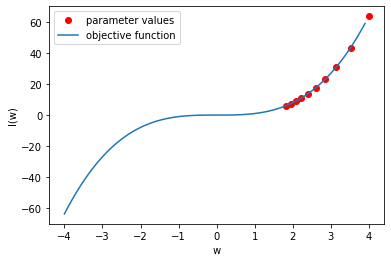

In [8]:
# Plot the model

plot_cubic(w, optimizer)

In [9]:
# Create a optimizer with momentum

optimizer = torch.optim.SGD(w.parameters(), lr=0.01, momentum=0.90)

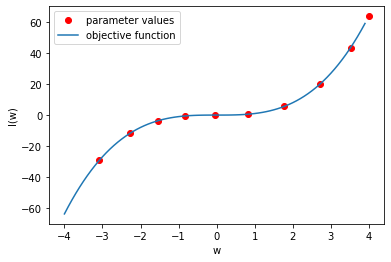

In [10]:
# Plot the model

plot_cubic(w, optimizer)

In this section, we will create a fourth order polynomial with a local minimum at <i>4</i> and a global minimum a <i>-2</i>. We will then see how the momentum parameter affects convergence to a global minimum. The fourth order polynomial is given by:

In [11]:
# Create a function to calculate the fourth order polynomial 

def fourth_order(yhat): 
    out = torch.mean(2 * (yhat ** 4) - 9 * (yhat ** 3) - 21 * (yhat ** 2) + 88 * yhat + 48)
    return out

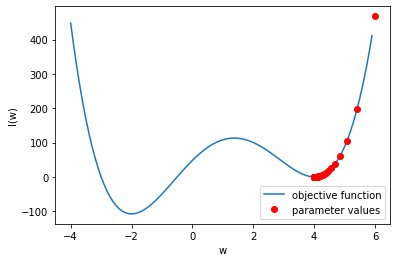

In [12]:
# Make the prediction without momentum

optimizer = torch.optim.SGD(w.parameters(), lr=0.001)
plot_fourth_order(w, optimizer)

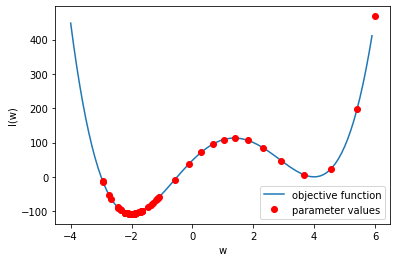

In [13]:
# Make the prediction with momentum

optimizer = torch.optim.SGD(w.parameters(), lr=0.001, momentum=0.9)
plot_fourth_order(w, optimizer)

<h2 id="Noise">Noise</h2>
In this section, we will create a fourth order polynomial with a local minimum at 4 and a global minimum a -2, but we will add noise to the function when the Gradient is calculated. We will then see how the momentum parameter affects convergence to a global minimum. 

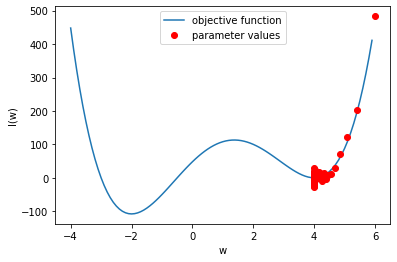

In [14]:
# Make the prediction without momentum when there is noise

optimizer = torch.optim.SGD(w.parameters(), lr=0.001)
plot_fourth_order(w, optimizer, std=10)

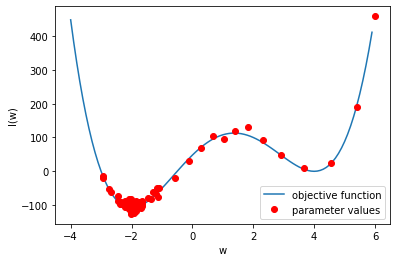

In [15]:
# Make the prediction with momentum when there is noise

optimizer = torch.optim.SGD(w.parameters(), lr=0.001,momentum=0.9)
plot_fourth_order(w, optimizer, std=10)

<h1>Loss Function with a High Condition Number with and Without Momentum</h1>

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

In [18]:
# Define the class for plot out the surface

class plot_error_surfaces(object):
    
    # Constructor
    def __init__(self, w_range, b_range, X, Y, n_samples=30, go=True):
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        w, b = np.meshgrid(W, B)    
        Z = np.zeros((n_samples, n_samples))
        count1 = 0
        self.y = Y.numpy()
        self.x = X.numpy()
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - w2 * self.x + b2) ** 2)
                count2 += 1
            count1 += 1
        self.Z = Z
        self.w = w
        self.b = b
        self.LOSS_list = {}
    
    # Setter
    def set_para_loss(self, model, name, loss):
        if (not (name in self.LOSS_list)):
            self.LOSS_list[name] = []
        w = list(model.parameters())[0].item()
        b = list(model.parameters())[1].item()
        self.LOSS_list[name].append({"loss": loss, "w": w, "b": b})
        
    # Plot the diagram
    def plot_ps(self, iteration=0):
        plt.contour(self.w, self.b, self.Z)
        count = 1
        if (len(self.LOSS_list) > 0):
            for key, value in self.LOSS_list.items():
                w = [v for d in value for (k, v) in d.items() if "w" == k]
                b = [v for d in value for (k, v) in d.items() if "b" == k]
                plt.scatter(w, b, cmap='viridis', marker='x', label=key)
            plt.title('Loss Surface Contour not to scale, Iteration: ' + str(iteration))
            plt.legend()
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()

In [19]:
# Define a class to create the dataset

class Data(Dataset):
    
    # Constructor
    def __init__(self):
        self.x = torch.arange(-2, 2, 0.1).view(-1, 1)
        self.f = 1 * self.x + 10000
        self.y = self.f + 0.1 * torch.randn(self.x.size())
        self.len = self.x.shape[0]
        
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

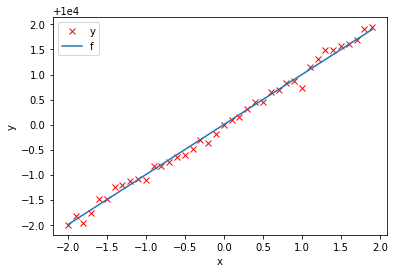

In [20]:
# Create a dataset object

dataset = Data()

# Plot the data

plt.plot(dataset.x.numpy(), dataset.y.numpy(), 'rx', label='y')
plt.plot(dataset.x.numpy(), dataset.f.numpy(), label='f')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

In [21]:
# Define linear regression class

class linear_regression(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

In [22]:
# Use the build-in function to create a criterion function

criterion = nn.MSELoss()

# Create a linear regression object and the optimizer without momentum

model = linear_regression(1, 1)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Create a linear regression object and the optimizer with momentum

model_momentum = linear_regression(1, 1)
optimizer_momentum = optim.SGD(model_momentum.parameters(), lr=0.01, momentum=0.2)

# Create a data loader

trainloader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

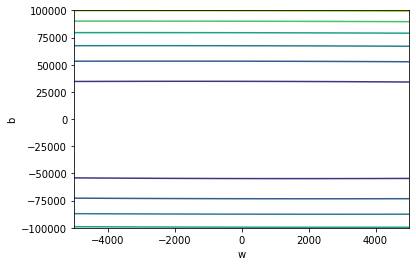

In [23]:
# Set parameters

model.state_dict()['linear.weight'][0] = -5000
model.state_dict()['linear.bias'][0] = -100000
model_momentum.state_dict()['linear.weight'][0] = -5000
model_momentum.state_dict()['linear.bias'][0] = -100000


# Plot the surface

get_surface = plot_error_surfaces(5000, 100000, dataset.x, dataset.y, 100, go=False)
get_surface.plot_ps()

<h2 id="BGD">Train the Model via Stochastic Gradient Descent</h2>

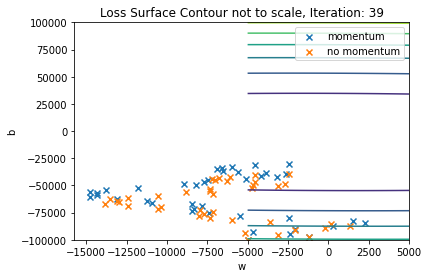

In [24]:
# Train the model

def train_model(epochs=1):
    for epoch in range(epochs):
        for i, (x, y) in enumerate(trainloader):
            #no momentum
            yhat = model(x)
            loss = criterion(yhat, y)

            #momentum
            yhat_m = model_momentum(x)
            loss_m = criterion(yhat_m, y)

            #apply optimization to momentum term and term without momentum 

            #for plotting 
            #get_surface.get_stuff(model, loss.tolist())
            #get_surface.get_stuff1(model_momentum, loss_m.tolist())

            get_surface.set_para_loss(model=model_momentum, name="momentum" ,loss=loss_m.tolist())
            get_surface.set_para_loss(model=model, name="no momentum" , loss=loss.tolist())

            optimizer.zero_grad()
            optimizer_momentum.zero_grad()
            loss.backward()
            loss_m.backward()
            optimizer.step()
            optimizer_momentum.step()
        get_surface.plot_ps(iteration=i)
train_model()

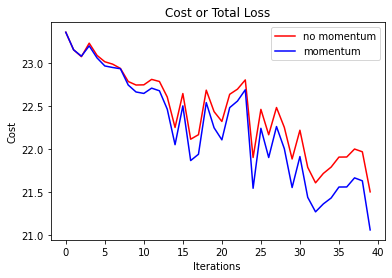

In [25]:
# Plot the loss

loss = [v for d in get_surface.LOSS_list["no momentum"] for (k, v) in d.items() if "loss" == k]
loss_m = [v for d in get_surface.LOSS_list["momentum"] for (k, v) in d.items() if "loss" == k]
plt.plot(np.log(loss), 'r', label='no momentum' )
plt.plot(np.log(loss_m), 'b', label='momentum' )
plt.title('Cost or Total Loss' )
plt.xlabel('Iterations ')
plt.ylabel('Cost')
plt.legend()
plt.show()

<h1>Neural Networks with Momentum</h1>

In [26]:
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, DataLoader

In [27]:
# Define a function for plot the decision region

def plot_decision_regions_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])
    X=data_set.x.numpy()
    y=data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1 , X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1 , X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    XX=torch.torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _,yhat=torch.max(model(XX),1)
    yhat=yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:]==0,0], X[y[:]==0,1], 'ro', label='y=0')
    plt.plot(X[y[:]==1,0], X[y[:]==1,1], 'go', label='y=1')
    plt.plot(X[y[:]==2,0], X[y[:]==2,1], 'o', label='y=2')
    plt.title("decision region")
    plt.legend()

In [28]:
# Create the dataset class

class Data(Dataset):
    
    #  modified from: http://cs231n.github.io/neural-networks-case-study/
    # Constructor
    def __init__(self, K=3, N=500):
        D = 2
        X = np.zeros((N * K, D)) # data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
          ix = range(N * j, N * (j + 1))
          r = np.linspace(0.0, 1, N) # radius
          t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
          X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
          y[ix] = j
    
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
            
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot_data(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y=0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y=1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(),self.x[self.y[:] == 2, 1].numpy(), 'go',label="y=2")
        plt.legend()

In [29]:
# Create neural network module

class Net(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
    
    # Prediction
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                activation = F.relu(linear_transform(activation))    
            else:
                activation = linear_transform(activation)
        return activation

In [30]:
# Define the function for training the model

def train(data_set, model, criterion, train_loader, optimizer, epochs=100):
    LOSS = []
    ACC = []
    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        LOSS.append(loss.item())
        ACC.append(accuracy(model,data_set))
        
    results ={"Loss":LOSS, "Accuracy":ACC}
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(LOSS,color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis = 'y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()
    return results

In [31]:
# Define a function for calculating accuracy

def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

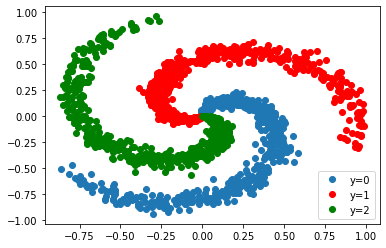

In [32]:
# Create the dataset and plot it

data_set = Data()
data_set.plot_data()
data_set.y = data_set.y.view(-1)

In [33]:
# Initialize a dictionary to contain the cost and accuracy

Results = {"momentum 0": {"Loss": 0, "Accuracy:": 0}, "momentum 0.1": {"Loss": 0, "Accuracy:": 0}}

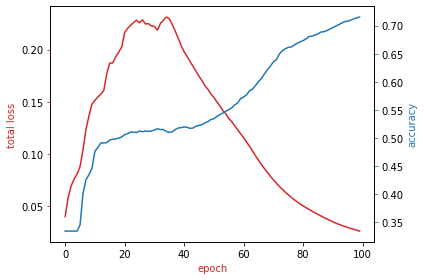

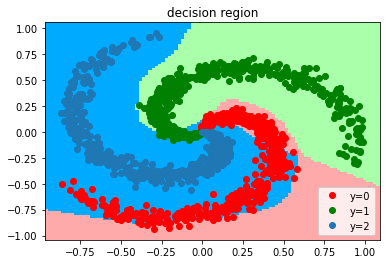

In [34]:
# Train a model with 1 hidden layer and 50 neurons with 0 momentum

Layers = [2, 50, 3]
model = Net(Layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
Results["momentum 0"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
plot_decision_regions_3class(model, data_set)

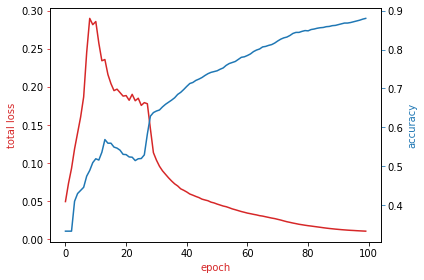

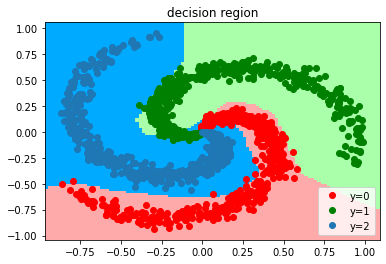

In [35]:
# Train a model with 1 hidden layer and 50 neurons with 0.1 momentum

Layers = [2, 50, 3]
model = Net(Layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.1)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
Results["momentum 0.1"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
plot_decision_regions_3class(model, data_set)

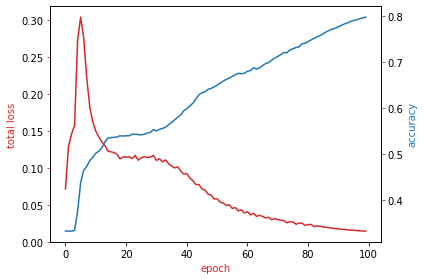

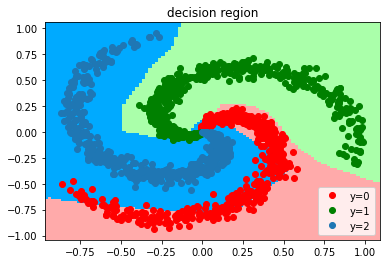

In [36]:
# Train a model with 1 hidden layer and 50 neurons with 0.2 momentum

Layers = [2, 50, 3]
model = Net(Layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.2)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
Results["momentum 0.2"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
plot_decision_regions_3class(model, data_set)

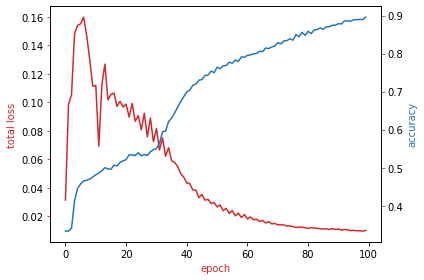

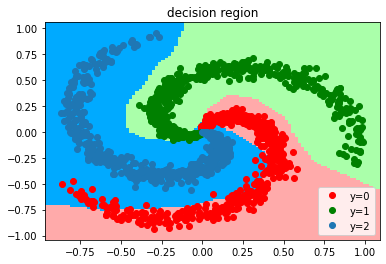

In [37]:
# Train a model with 1 hidden layer and 50 neurons with 0.4 momentum

Layers = [2, 50, 3]
model = Net(Layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.4)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
Results["momentum 0.4"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
plot_decision_regions_3class(model, data_set)

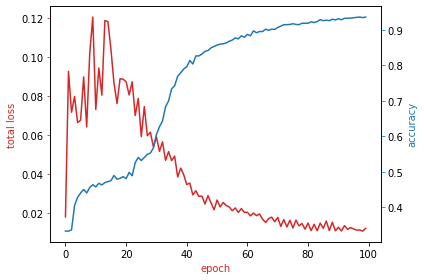

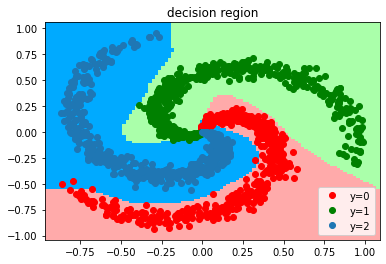

In [38]:
# Train a model with 1 hidden layer and 50 neurons with 0.5 momentum

Layers = [2, 50, 3]
model = Net(Layers)
learning_rate = 0.10
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)
train_loader = DataLoader(dataset=data_set, batch_size=20)
criterion = nn.CrossEntropyLoss()
Results["momentum 0.5"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)
plot_decision_regions_3class(model,data_set)

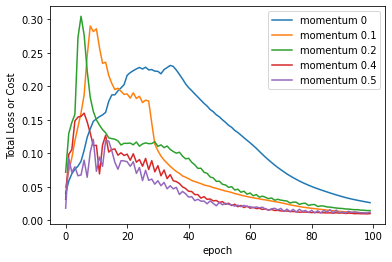

In [39]:
# Plot the Loss result for each term

for key, value in Results.items():
    plt.plot(value['Loss'],label=key)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Total Loss or Cost')

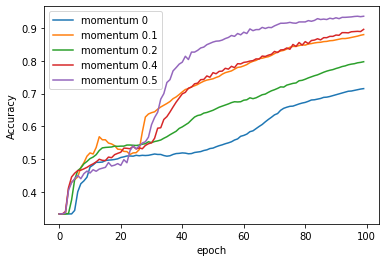

In [40]:
# Plot the Accuracy result for each term

for key, value in Results.items():
    plt.plot(value['Accuracy'],label=key)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')